In [21]:
import numpy as np
import tensorflow as tf
import random as python_random
# import tensorflow_addons as tfa
import tensorflow.keras as keras
from PIL import Image
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Flatten, Dense
import argparse

random_seed = 123456

2024-11-17 15:34:06.728141: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 15:34:06.733074: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 15:34:06.824281: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 15:34:06.826071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-17 15:34:08.923183: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [38]:
import csv
from datetime import datetime

def get_date_time_from_hash(file_path, search_hash):
    """
    Retrieves the `dex_date` for the given hash and formats it as a timestamp.
    
    Args:
        file_path (str): Path to the CSV file.
        search_hash (str): The hash to search for.
    
    Returns:
        datetime: The formatted timestamp or None if the hash is not found.
    """
    with open(file_path, 'r') as csv_file:
        reader = csv.DictReader(csv_file, fieldnames=[
            'hash1', 'hash2', 'hash3', 'date_time', 'number1',
            'package', 'number2', 'number3', 'dex_date', 'number4', 'source'
        ])
        for row in reader:
            if row['hash1'] == search_hash:
                try:
                    # Convert dex_date to the required format
                    timestamp = datetime.strptime(row['dex_date'], '%Y-%m-%d %H:%M:%S')
                    return timestamp
                except ValueError as e:
                    print(f"Error parsing date: {e}")
                    return None
    return None

# Example usage:
csv_file_path = "/home/laura/University/ai-security/dexray_data/metadata.csv"  # Replace with your actual file path
search_hash = "0ABC4725E1470A5B9032F531310A4CF7ABDFFD28465FE12ECB7732A6528C609C"
timestamp = get_date_time_from_hash(csv_file_path, search_hash)
print(f"Timestamp: {timestamp}")

Timestamp: 2019-03-17 10:56:47


In [47]:
import os
import numpy as np
from PIL import Image

def load_images_from_directory_grayscale(directory_path, image_size=(224, 224)):
    """
    Load and preprocess grayscale images from a directory into a numpy array,
    flattening each image into a one-dimensional array.

    Args:
        directory_path (str): Path to the directory containing .png images.
        image_size (tuple): Tuple specifying the desired size (width, height).

    Returns:
        np.ndarray: A 2D array where each row is a flattened image (num_images, num_pixels).
    """
    images = []
    t = []
    for file_name in sorted(os.listdir(directory_path)):  # Ensure reproducible order
        if file_name.endswith('.png'):
            t.append(get_date_time_from_hash(csv_file_path,file_name[:-4]))
            img_path = os.path.join(directory_path, file_name)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(image_size)  # Resize to uniform size
            img_array = np.array(img).flatten()  # Convert to numpy array and flatten
            img_array = img_array[:, np.newaxis]  # Add a new axis for shape (num_pixels, 1)
            images.append(img_array)
    
    return np.stack(t),np.stack(images)


In [59]:


image_size = (128, 128)  # Change size as needed
directory_path = "/home/laura/Code/DexRay/apk_images_true/goodware"
t1, X1 = load_images_from_directory_grayscale(directory_path, image_size=image_size)

directory_path = "/home/laura/Code/DexRay/apk_images_true/malware"
t2, X2 = load_images_from_directory_grayscale(directory_path, image_size=image_size)

print(f"Shape of X: {X1.shape}")  
print(f"Shape of X2: {X2.shape}") 

X = np.concatenate((X1, X2), axis=0)
print(f"Shape of X: {X.shape}") 

t = np.concatenate((t1, t2), axis=0)
print(t)

Shape of X: (57, 16384, 1)
Shape of X2: (42, 16384, 1)
Shape of X: (99, 16384, 1)
[datetime.datetime(2019, 8, 19, 21, 35, 36)
 datetime.datetime(2019, 4, 15, 6, 22, 5)
 datetime.datetime(2019, 12, 11, 18, 17, 57)
 datetime.datetime(2019, 8, 21, 5, 25, 56)
 datetime.datetime(2019, 3, 17, 10, 56, 47)
 datetime.datetime(2019, 6, 24, 16, 55, 44)
 datetime.datetime(2019, 4, 14, 1, 21, 56)
 datetime.datetime(2019, 2, 26, 14, 15, 53)
 datetime.datetime(2019, 12, 1, 9, 17, 16)
 datetime.datetime(2019, 11, 6, 12, 51, 18)
 datetime.datetime(2019, 4, 23, 1, 1, 44)
 datetime.datetime(2019, 3, 17, 18, 55, 35)
 datetime.datetime(2019, 9, 27, 0, 53, 40)
 datetime.datetime(2019, 9, 5, 13, 35, 29)
 datetime.datetime(2019, 8, 3, 0, 18, 41)
 datetime.datetime(2019, 3, 5, 16, 18, 48)
 datetime.datetime(2019, 4, 6, 0, 13, 24)
 datetime.datetime(2019, 8, 23, 5, 20, 39)
 datetime.datetime(2019, 11, 13, 4, 8, 36)
 datetime.datetime(2019, 7, 20, 1, 6, 4)
 datetime.datetime(2020, 2, 20, 20, 44, 43)
 datetime.da

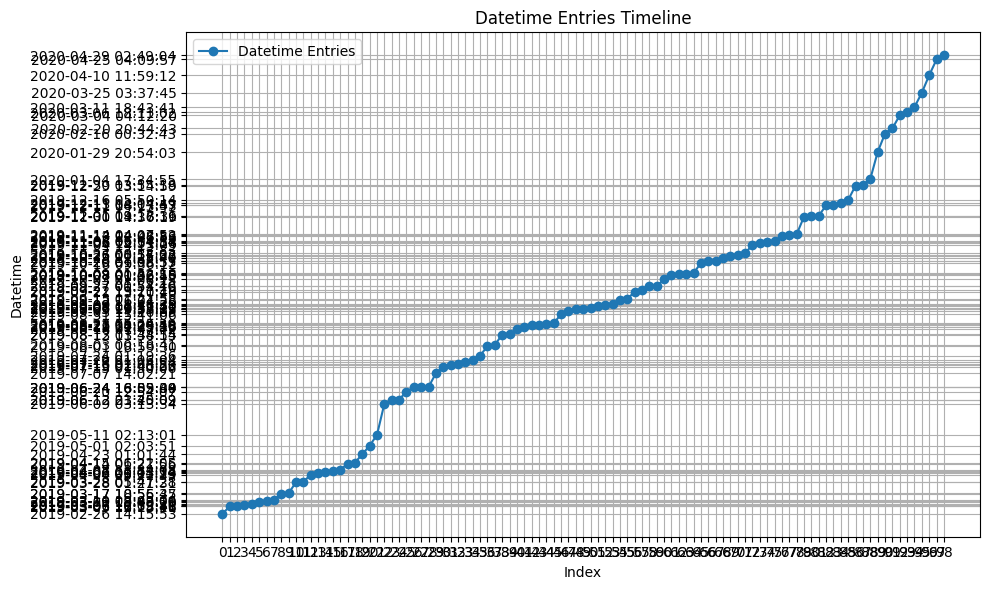

2019-02-26 14:15:53
2020-04-29 02:49:04


In [66]:
import matplotlib.pyplot as plt
import numpy as np
import datetime

def plot_datetime_array(datetime_array):
    """
    Plots the elements of a datetime array on a timeline.
    
    Parameters:
        datetime_array (np.array): Array of datetime.datetime objects
    """
    # Ensure the array is sorted for better visualization
    sorted_datetimes = np.sort(datetime_array)
    
    # Convert datetime to numeric indices for plotting
    indices = range(len(sorted_datetimes))
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(indices, sorted_datetimes, marker='o', linestyle='-', label='Datetime Entries')
    
    # Set labels and title
    plt.xlabel("Index")
    plt.ylabel("Datetime")
    plt.title("Datetime Entries Timeline")
    plt.grid(True)
    plt.legend()
    plt.xticks(indices)  # Ensure indices are visible
    
    # Display datetime values as string labels
    plt.gca().set_yticks(sorted_datetimes)
    plt.gca().set_yticklabels([dt.strftime('%Y-%m-%d %H:%M:%S') for dt in sorted_datetimes])
    
    plt.tight_layout()
    plt.show()

# Example array of datetime objects
datetime_array = np.array([
    datetime.datetime(2019, 8, 19, 21, 35, 36),
    datetime.datetime(2019, 4, 15, 6, 22, 5),
    datetime.datetime(2020, 5, 25, 14, 30, 0),
    datetime.datetime(2018, 12, 31, 23, 59, 59),
])

# Call the function
plot_datetime_array(t)
print(min(t))
print(max(t))

In [24]:
# Create an array of 57 zeros
zeros = np.zeros(57, dtype=int)

# Create an array of 43 ones
ones = np.ones(42, dtype=int)

# Concatenate the arrays
labels = np.concatenate((zeros, ones))

print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [25]:
X_norm = X.astype('float32') / 255.0 
Y = labels.astype('float32')  # Ensure correct dtype

In [26]:
IMG_SIZE=128

model_architecture = Sequential()
model_architecture.add(
    Conv1D(
        filters=64,
        kernel_size=12,
        activation="relu",
        input_shape=(IMG_SIZE * IMG_SIZE, 1),
    )
)
model_architecture.add(MaxPooling1D(pool_size=12))
model_architecture.add(Conv1D(filters=128, kernel_size=12, activation="relu"))
model_architecture.add(MaxPooling1D(pool_size=12))
model_architecture.add(Flatten())
model_architecture.add(Dense(64, activation="sigmoid"))
model_architecture.add(Dense(1, activation="sigmoid"))

2024-11-17 15:34:28.448624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-17 15:34:28.449679: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [27]:
model = keras.models.clone_model(model_architecture)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
    # metrics=[
    #     "accuracy",
    #     tf.keras.metrics.Precision(),
    #     tf.keras.metrics.Recall(),
    #     tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5),
    # ],
)

In [81]:
from tesseract import temporal

splits = temporal.time_aware_train_test_split(X, Y, t, train_size=3, test_size=1, granularity='month')

In [82]:
X_train, X_test, y_train, y_test, t_train, t_test = splits
print(len(X_train))
print(len(X_test))

22
12


In [83]:
from tesseract import evaluation, temporal, metrics, mock

results = evaluation.fit_predict_update(model, *splits)

0it [00:00, ?it/s]

1/1 [==============================] - 0s 108ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
1it [00:00,  1.64it/s]

1/1 [==============================] - 0s 60ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2it [00:00,  2.59it/s]

1/1 [==============================] - 0s 178ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
3it [00:01,  2.84it/s]

1/1 [==============================] - 0s 273ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
4it [00:01,  2.77it/s]

1/1 [==============================] - 0s 126ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
5it [00:01,  2.97it/s]

1/1 [==============================] - 0s 271ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
6it [00:02,  2.88it/s]

1/1 [==============================] - 0s 69ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
7it [00:02,  3.06it/s]

1/1 [==============================] - 0s 94ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
8it [00:02,  3.21it/s]

1/1 [==============================] - 0s 47ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
9it [00:02,  3.41it/s]

1/1 [==============================] - 0s 49ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
10it [00:02,  3.59it/s]

1/1 [==============================] - 0s 49ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
11it [00:02,  3.75it/s]

1/1 [==============================] - 0s 46ms/step


/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/laura/.pyenv/versions/3.10.15/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [84]:
metrics.print_metrics(results)

------------+------------------------------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9     10     11     12   
------------+------------------------------------------------------------------------------------
Actual pos  |      2      1      4      6      7      2      4      2      2      1      1      1
Actual neg  |      5      6      6      6      6      6      3      1      1      3      1      0
Total       |      7      7     10     12     13      8      7      3      3      4      2      1
------------+------------------------------------------------------------------------------------
TPR         |  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
FPR         |  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000    nan
TNR         |  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000    nan
FNR         |  1.0